In [ ]:
# develop-translation-operator.ipynb
#
# Bryan Daniels
# 2023/9/26
#
# Using the continuous dynamics developed in 'initial-model-brainstorming', create
# a translation operator that can move the edge attractor along the attractor manifold.
#

In [32]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from toolbox import defaultFigure
defaultFigure.setDefaultParams()

from laplace_network import laplace_network,find_edge_location

In [18]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

N = 50 # number of units
J = 2 # constant interaction strength between neighbors

net = laplace_network(N,J,J_bump_edge=0.)

In [19]:
# find stationary states (fixed points) that look like an edge
center_list = range(0,N,2)
fp_list = []
for center in center_list:
    fp = net.find_edge_state(center,method='translate')#method='minimize')
    fp_list.append(fp)

In [20]:
# find stationary states (fixed points) that look like an edge using alternate method
center_list = range(0,N,2)
fp_list_minimize = []
for center in center_list:
    fp = net.find_edge_state(center,method='minimize')
    fp_list_minimize.append(fp)

In [21]:
# translation input should just be (proportional to) the derivative of edge fixed points
# with respect to position
translation_input_list = np.diff(fp_list,axis=0)

(-2.45, 51.45, -4.0, 4.0)

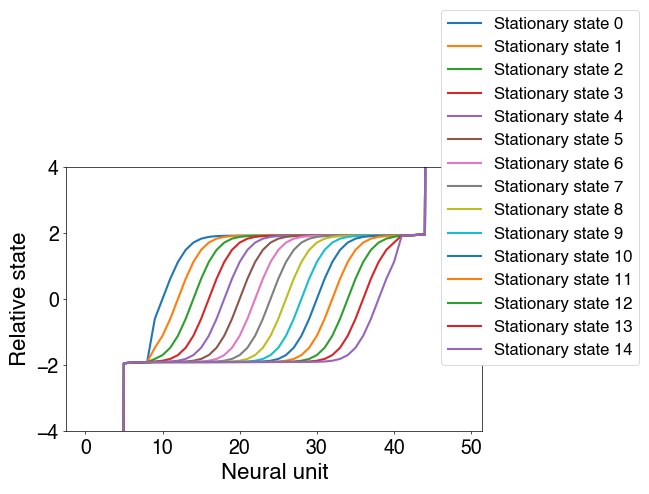

In [22]:
for i,fp in enumerate(fp_list[5:20]):
    plt.plot(fp[:net.Npopulation],label='Stationary state {}'.format(i))
plt.xlabel('Neural unit')
plt.ylabel('Relative state')
leg = plt.legend(loc=(0.9,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-4,ymax=+4)

(-2.45, 51.45, -4.0, 4.0)

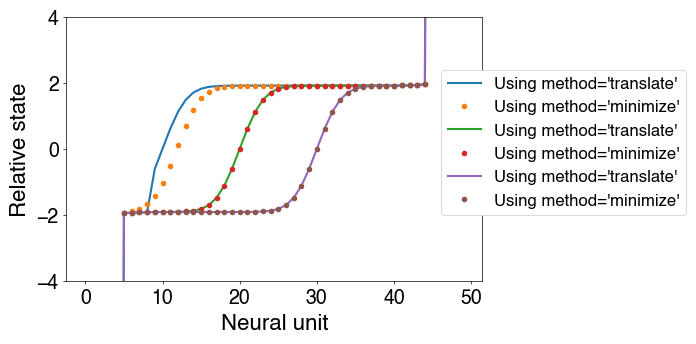

In [23]:
# compare edges found using method='translate' and method='minimize'
for fp,fp_minimize in zip(fp_list[5:20][::5],fp_list_minimize[5:20][::5]):
    plt.plot(fp[:net.Npopulation],label="Using method='translate'")
    plt.plot(fp_minimize[:net.Npopulation],'.',label="Using method='minimize'")
plt.xlabel('Neural unit')
plt.ylabel('Relative state')
leg = plt.legend(loc=(0.9,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-4,ymax=+4)

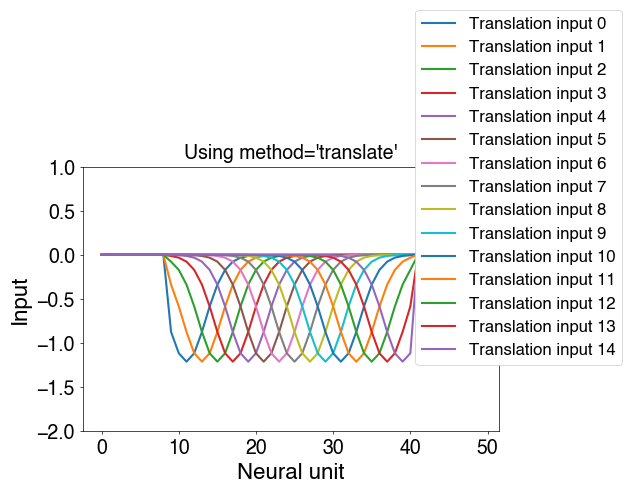

In [24]:
for i,trans_input in enumerate(translation_input_list[5:20]):
    plt.plot(trans_input[:net.Npopulation],label='Translation input {}'.format(i))
plt.xlabel('Neural unit')
plt.ylabel('Input')
leg = plt.legend(loc=(0.8,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-2,ymax=+1)
plt.title("Using method='translate'");

# are these simply gaussian?
#plt.plot(range(N),6*scipy.stats.distributions.norm.pdf(range(N),loc=25,scale=net.kernel_width),lw=5)

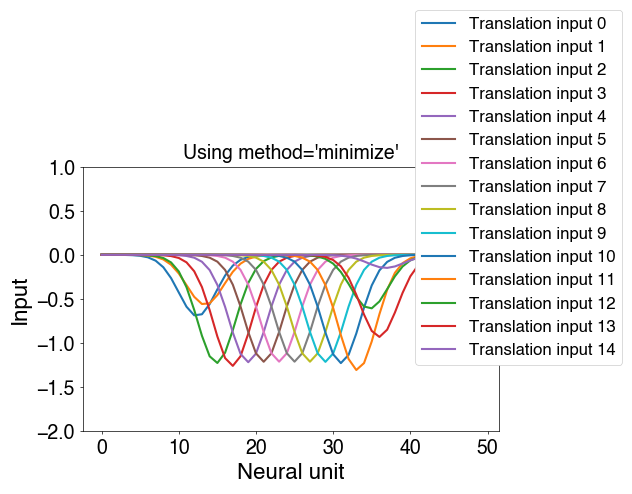

In [25]:
# using method='minimize'
translation_input_list_minimize = np.diff(fp_list_minimize,axis=0)
for i,trans_input in enumerate(translation_input_list_minimize[5:20]):
    plt.plot(trans_input[:net.Npopulation],label='Translation input {}'.format(i))
plt.xlabel('Neural unit')
plt.ylabel('Input')
leg = plt.legend(loc=(0.8,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-2,ymax=+1)
plt.title("Using method='minimize'");

# 2023/9/28 Can we move an edge at constant velocity?

In [26]:
noise_var = 1e-4 # 0.1 # strength of noise (variance added per unit time)
t_final = 50 #100 #20
delta_t = 0.001 #0.001
input_times = np.arange(0,t_final+delta_t,delta_t)[:-1] # don't need an input at the final timepoint
seed = 12345
center = 25

# start at edge state
edge_state = net.find_edge_state(center)

# apply input corresponding to moving delta_n in 1 unit of time
# delta_n = -1 #10 #0.5 # in units of number of neurons
# edge_state_new = net.find_edge_state(center + delta_n)
# translation_input = edge_state_new - edge_state

# apply time-varying input
# goal: move delta_n per unit of time
translation_input_time_varying = []
delta_n = 0.5
edge_state_old = edge_state.copy()
for t in range(t_final):
    # we will only change the input once every time unit
    delta_n_total = delta_n*(t+1)
    edge_state_new = net.find_edge_state(center + delta_n_total)
    translation_input = edge_state_new - edge_state_old
    for t_micro in range(int(1./delta_t)):
        translation_input_time_varying.append(translation_input)
    edge_state_old = edge_state_new.copy()

# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final,
                               noise_var,
                               additional_input=translation_input_time_varying,
                               seed=seed,
                               delta_t=delta_t)
rates = np.tanh(states)

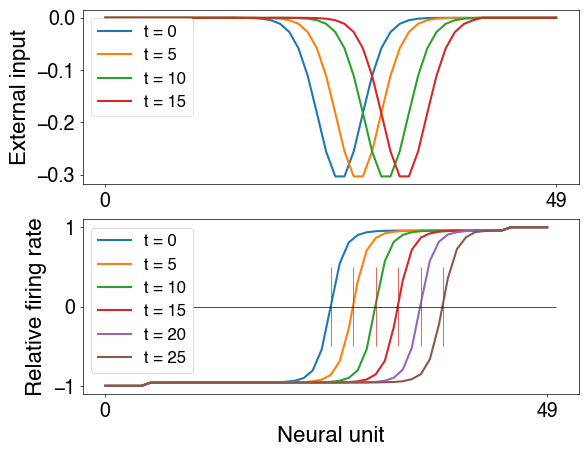

In [27]:
# input plot
plt.subplot(2,1,1)
for t in range(0,20,5):
    plt.plot(translation_input_time_varying[int(t/delta_t)][:net.Npopulation],
             label='t = {}'.format(t))
leg = plt.legend()
plt.xticks(ticks=[0,N-1],labels=[0,N-1])
plt.ylabel('External input')
#plt.xlabel('Neural unit')
defaultFigure.makePretty(leg=leg)

# firing rate plot
plt.subplot(2,1,2)
for t in range(0,30,5):
    plt.plot(rates.loc[t][:net.Npopulation],label="t = {}".format(t))
    plt.vlines([center+delta_n*t],-0.5,0.5,color='C3',lw=0.5)
plt.hlines(0,0,50,color='k',lw=0.5)
    
plt.xlabel('Neural unit')
plt.ylabel('Relative firing rate')
leg = plt.legend(framealpha=1)
plt.xticks(ticks=[0,N-1],labels=[0,N-1]);
defaultFigure.makePretty(leg=leg)

plt.subplots_adjust(bottom=0.15,top=0.95)
#plt.savefig('230928_move_edge_constant_velocity.pdf')

# 2023/10/17 Speed decaying in time

In [28]:
noise_var = 1e-4 # 0.1 # strength of noise (variance added per unit time)
i_final = 5 #(t increases exponentially with i) #100 #20
t_final = 2**(i_final-1)
delta_t = 0.001 #0.001
input_times = np.arange(0,t_final+delta_t,delta_t)[:-1] # don't need an input at the final timepoint
seed = 12345
center = 25

# start at edge state
edge_state = net.find_edge_state(center)

# apply input corresponding to moving delta_n in 1 unit of time
# delta_n = -1 #10 #0.5 # in units of number of neurons
# edge_state_new = net.find_edge_state(center + delta_n)
# translation_input = edge_state_new - edge_state

# apply time-varying input
# goal: move delta_n per unit of time
# translation_input_time_varying = []
# delta_n = 0.5
# edge_state_old = edge_state.copy()
# for t in range(t_final):
#     # we will only change the input once every time unit
#     delta_n_total = delta_n*(t+1)
#     edge_state_new = net.find_edge_state(center + delta_n_total)
#     translation_input = edge_state_new - edge_state_old
#     for t_micro in range(int(1./delta_t)):
#         translation_input_time_varying.append(translation_input)
#     edge_state_old = edge_state_new.copy()

# apply time-varying input that decays in time
# goal: move delta_n/t per unit of time
# (see notes 2023/10/17)
translation_input_time_varying = []
delta_n = 0.5
edge_state_old = edge_state.copy()
for i in range(i_final):
    # we will only change the input once every 2^i time units
    # (the first timestep is different)
    if i > 0:
        delta_t_step = 2**(i-1)
    elif i == 0:
        delta_t_step = 1
    delta_n_total = 1 + delta_n*i
    edge_state_new = net.find_edge_state(center + delta_n_total)
    translation_input = (edge_state_new - edge_state_old)/delta_t_step
    for t_micro in range(int(delta_t_step/delta_t)):
        translation_input_time_varying.append(translation_input)
    edge_state_old = edge_state_new.copy()
    
# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final,
                               noise_var,
                               additional_input=translation_input_time_varying,
                               seed=seed,
                               delta_t=delta_t)
rates = np.tanh(states)

In [11]:
len(rates)

16001

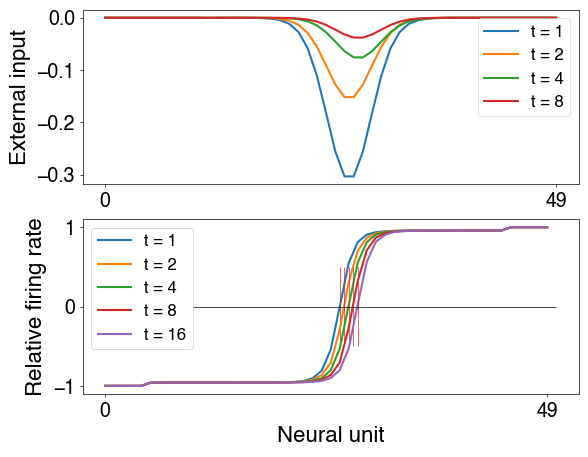

In [30]:
# input plot
plt.subplot(2,1,1)
i_list = list(range(i_final))
times = [2**i for i in i_list] #[0,1,2,4,8]
for t in times[:-1]:
    plt.plot(translation_input_time_varying[int(t/delta_t)][:net.Npopulation],
             label='t = {}'.format(t))
leg = plt.legend()
plt.xticks(ticks=[0,N-1],labels=[0,N-1])
plt.ylabel('External input')
#plt.xlabel('Neural unit')
defaultFigure.makePretty(leg=leg)

# firing rate plot
plt.subplot(2,1,2)
for i,t in zip(i_list,times):
    plt.plot(rates.loc[t][:net.Npopulation],
             label="t = {}".format(t))
    plt.vlines([center + 1 + delta_n*i],-0.5,0.5,color='C3',lw=0.5)
plt.hlines(0,0,50,color='k',lw=0.5)
    
plt.xlabel('Neural unit')
plt.ylabel('Relative firing rate')
leg = plt.legend(framealpha=1)
plt.xticks(ticks=[0,N-1],labels=[0,N-1]);
defaultFigure.makePretty(leg=leg)

plt.subplots_adjust(bottom=0.15,top=0.95)
#plt.savefig('230928_move_edge_constant_velocity.pdf')

Text(0, 0.5, 'Edge location')

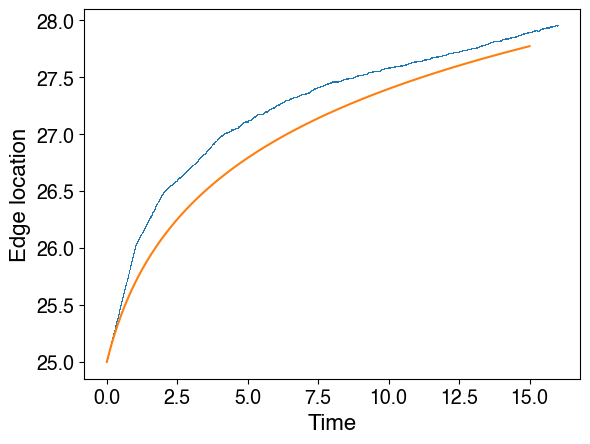

In [35]:
plt.plot(rates.index,[find_edge_location(rates.loc[i])[0] for i in rates.index],',')
plt.plot(rates.index[1000:]-1,25+np.log(rates.index[1000:]))
plt.xlabel('Time')
plt.ylabel('Edge location')

# 2023/10/18 Try again with continuously varying input

In [36]:
fp1 = net.find_edge_state(25)
fp2 = net.find_edge_state(25.0001)

In [37]:
fp1_min = net.find_edge_state(25,method='minimize')
fp2_min = net.find_edge_state(25.0001,method='minimize')

In [38]:
fp2_big_step = net.find_edge_state(26)

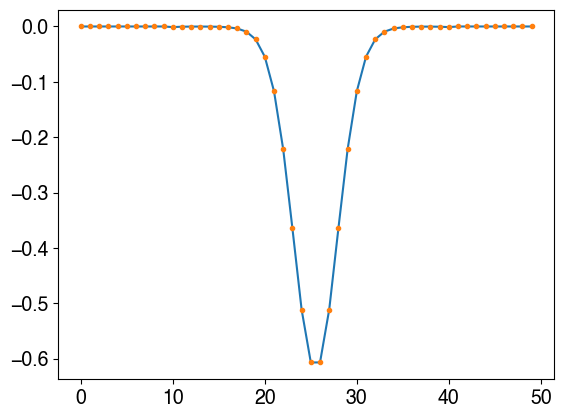

In [40]:
plt.plot((fp2-fp1)[:net.Npopulation]*10000)
plt.plot((fp2_big_step-fp1)[:net.Npopulation],'.')
#plt.plot((fp2_min-fp1_min)*10000)

(-2.45, 51.45, -2.0, 2.0)

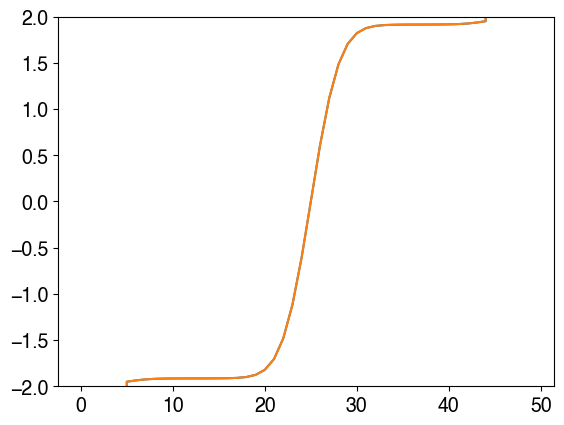

In [41]:
plt.plot(fp1[:net.Npopulation])
plt.plot(fp1_min[:net.Npopulation])
plt.axis(ymin=-2,ymax=+2)

(-2.45, 51.45, -2.0, 2.0)

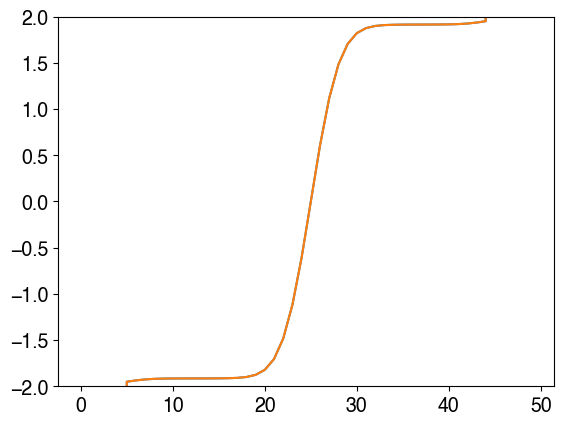

In [42]:
plt.plot(fp2[:net.Npopulation])
plt.plot(fp2_min[:net.Npopulation])
plt.axis(ymin=-2,ymax=+2)

In [48]:
noise_var = 1e-4 # 0.1 # strength of noise (variance added per unit time)
i_final = 5 #(t increases exponentially with i) #100 #20
t_start = 1. #0.1 #1. #0.5 #1.
t_final = t_start + 2**(i_final-1)
delta_t = 0.001 #0.001
input_times = np.arange(t_start,t_final+delta_t,delta_t)[:-1] # don't need an input at the final timepoint
seed = 12345
center = 25

# start at edge state
edge_state = net.find_edge_state(center)

# apply time-varying input that decays in time
# goal: move 1/t per unit of time

translation_input_time_varying = []

edge_state_old = edge_state.copy()
for t in input_times:
    n = center + np.log(t)
    edge_state_new = net.find_edge_state(n)
    translation_input = (edge_state_new - edge_state_old)/delta_t
    translation_input_time_varying.append(translation_input)
    edge_state_old = edge_state_new.copy()
    
# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final-t_start,
                               noise_var,
                               additional_input=translation_input_time_varying,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states.index = states.index + t_start
rates = np.tanh(states)

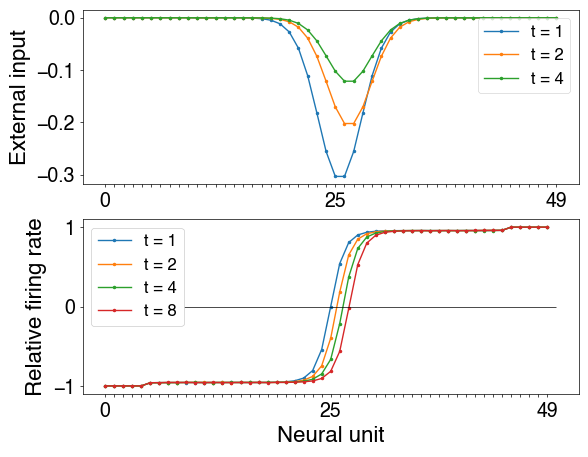

In [52]:
# input plot
plt.subplot(2,1,1)
i_list = list(range(i_final))
times = [1,2,4,8] #[0.1,1,2,4] #[2**i for i in i_list] #[0,1,2,4,8]
for t in times[:-1]:
    plt.plot(translation_input_time_varying[int(t/delta_t)][:net.Npopulation],
             '.-',label='t = {}'.format(t),lw=1,ms=3)
leg = plt.legend()
labels=['' for i in range(N)]
labeled_n = [0,int(N/2),N-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(N),labels=labels)
plt.ylabel('External input')
#plt.xlabel('Neural unit')
defaultFigure.makePretty(leg=leg)

# firing rate plot
plt.subplot(2,1,2)
for i,t in zip(i_list,times):
    plt.plot(rates.loc[t][:net.Npopulation],
             '.-',label="t = {}".format(t),lw=1,ms=3)
    #plt.vlines([center + 2/3*i],-0.5,0.5,color='C3',lw=0.5)
plt.hlines(0,0,50,color='k',lw=0.5)
    
plt.xlabel('Neural unit')
plt.ylabel('Relative firing rate')
leg = plt.legend(framealpha=1)
labels=['' for i in range(N)]
labeled_n = [0,int(N/2),N-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(N),labels=labels)
defaultFigure.makePretty(leg=leg)

plt.subplots_adjust(bottom=0.15,top=0.95)
#plt.savefig('231018_move_edge_decaying_velocity.pdf')

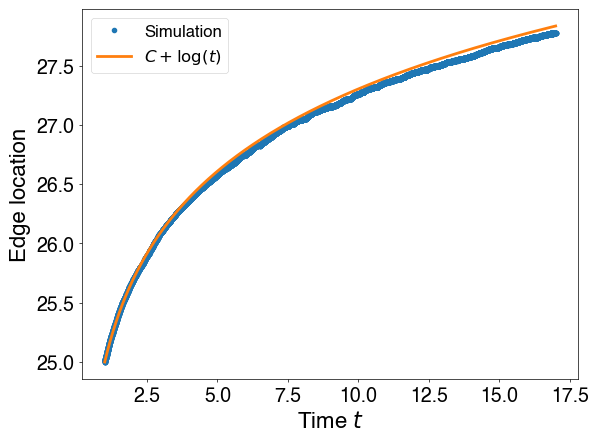

In [53]:
plt.plot(rates.index,[find_edge_location(rates.loc[i])[0] for i in rates.index],'.',label='Simulation')
plt.plot(rates.index,center+np.log(rates.index),label='$C+ \log(t)$',lw=2)
plt.xlabel('Time $t$')
plt.ylabel('Edge location')
leg = plt.legend()
defaultFigure.makePretty(leg=leg)
#plt.savefig('231018_edge_location_vs_time.pdf')

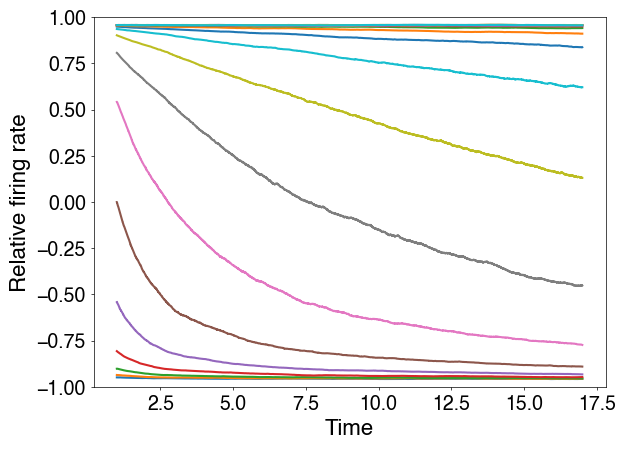

In [54]:
# plot rate over time for a particular neuron
neuron_indices = range(20,40)
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    plt.plot(rates[name],label=name)
#leg = plt.legend()
plt.xlabel('Time')
plt.ylabel('Relative firing rate')
plt.axis(ymin=-1,ymax=1)
plt.subplots_adjust(left=0.15,right=0.95)
defaultFigure.makePretty(leg=leg)
#plt.savefig('231018_firing_rate_vs_time.pdf')